<a href="https://colab.research.google.com/github/Styrys/Cricket_win_predictor/blob/main/CRICKET_WIN_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F22548%2F28917%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240718%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240718T162147Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5cf631be87699dc1866b8aab08d607480953e5bbb8ebe55c580cbefbcc4f8cefb4e31ee316cb074e5d3f4dfda7b1fc5955e7459ca5c4cd53bc5815f495ac09dabf0e3b6f02eeeff00e03244cccbf7f781fc1cf2f42298b7b7a0f23bb084e21a8beb87dde379b1cec7bc83c38ee416cbeb2e142ab4b2778257ed08d9c4d84dd0844f4e47c88e9a250c3d8bf0142253f61ff9de53287eb6dd8145df9f484206e2f3baaea4904e2a8130d09ff9bb48d7607233730c5f3d24c7c3186c279bd51518e281736f7089973f0fe0010a4cda8951472ca0b8f49726722e29630d01d9bc4c61fa43a25aada874f915002237e951b14e81e0a1944101bc09f242c26a7c57a17'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #Used for ploting
import seaborn as sns #used for Visualiztion

# Input data files are available in the "../input/" directory.

import os
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer  #could have used tf-idf feature extractor
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

['Trainmatches.csv', 'TestDeliveries.csv', 'Testmatches.csv', 'submission.csv', 'TrainDeliveries.csv']


In [ ]:
import sys
#print(sys.path)

Intially we are taking two data sets **Trainmatches.csv** and **TrainDeliveries.csv** and load them into a data frame.

In [ ]:
# Reading the Deliveries and Matches Dataset
TRM=pd.read_csv("../input/Trainmatches.csv")
TRM.index=TRM["id"]
TRD=pd.read_csv("../input/TrainDeliveries.csv")

In [ ]:
TRM.head()

,id,season,city,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue
id,,,,,,,,,,,,,,
1,1,2017,City1,Team1,Team5,Team5,field,normal,0,Team1,35,0,Player 467,Stadium1
2,2,2017,City2,Team2,Team4,Team4,field,normal,0,Team4,0,7,Player 405,Stadium2
3,3,2017,City3,Team3,Team6,Team6,field,normal,0,Team6,0,10,Player 85,Stadium3
4,4,2017,City4,Team4,Team8,Team8,field,normal,0,Team8,0,6,Player 145,Stadium4
5,5,2017,City5,Team5,Team7,Team5,bat,normal,0,Team5,15,0,Player 209,Stadium5


In [ ]:
TRD.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Team1,Team5,1,1,Player 105,Player 354,Player 431,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Team1,Team5,1,2,Player 105,Player 354,Player 431,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Team1,Team5,1,3,Player 105,Player 354,Player 431,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Team1,Team5,1,4,Player 105,Player 354,Player 431,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Team1,Team5,1,5,Player 105,Player 354,Player 431,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN


Intially we plot a histogram to find number of matches that each team won in IPL and also find which teams stood out.

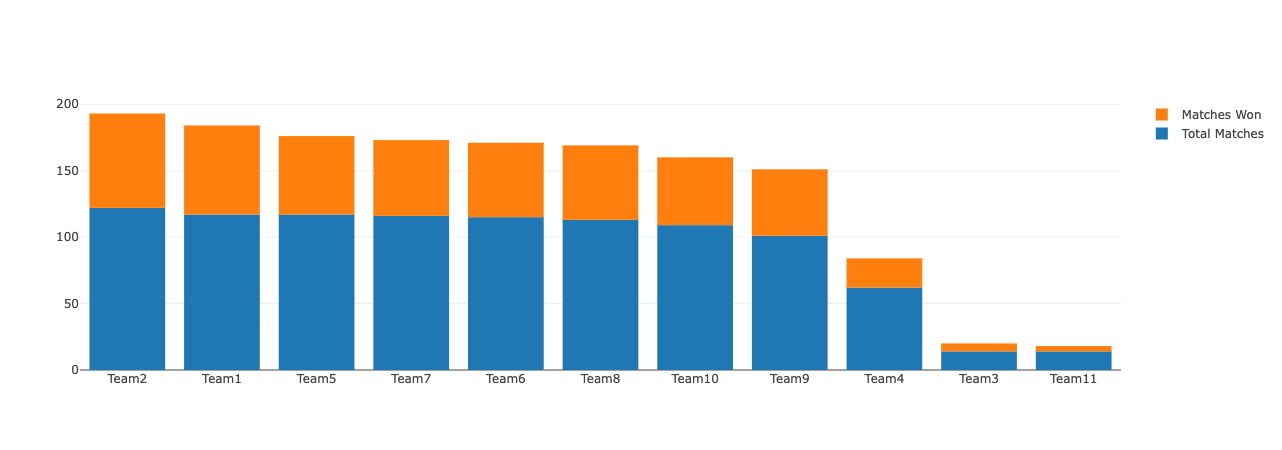

In [ ]:
matches_played_byteams=pd.concat([TRM['team1'],TRM['team2']])
matches_played_byteams=matches_played_byteams.value_counts().reset_index()
matches_played_byteams.columns=['Team','Total Matches']
matches_played_byteams['wins']=TRM['winner'].value_counts().reset_index()['winner']
matches_played_byteams.set_index('Team',inplace=True)

trace1 = go.Bar(
    x=matches_played_byteams.index,
    y=matches_played_byteams['Total Matches'],
    name='Total Matches'
)
trace2 = go.Bar(
    x=matches_played_byteams.index,
    y=matches_played_byteams['wins'],
    name='Matches Won'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')


This graph shows that total matches that each team played(agianst each other in the dataset) and the number of matches they won.

*** DROPPING THE NULL VALUES ***

Checking up the null values and damaged data values in the dataset and removing them will give the correct ouput .

In [ ]:
"""
null_columns=TRM.columns[TRM.isnull().any()]
TRM[null_columns].isnull().sum()

print(TRM[TRM["winner"].isnull()][null_columns])
# Dropping the row
TRM=TRM.drop(index=301)
print(TRM[TRM["winner"].isnull()][null_columns])
"""

'\nnull_columns=TRM.columns[TRM.isnull().any()]\nTRM[null_columns].isnull().sum()\n\nprint(TRM[TRM["winner"].isnull()][null_columns])\n# Dropping the row \nTRM=TRM.drop(index=301)\nprint(TRM[TRM["winner"].isnull()][null_columns])\n'

Now create the feature table to train our data and create the table . All the matches are identified by the *** match_id *** so we can make this field as the primary_index of the  feature table and we have to find that total matches played .
From the given dataset we can infer that match_id lies from 1 to 500 matches.
Now setting up the team details like which teams are going to play in the match on the respective id's.So add *** Team A *** and *** Team B *** columns to the *** FT *** Dataframe

In [ ]:
# Creating Feature Table
FT=pd.DataFrame()

# Making match_id as the index
FT["match_id"]=TRM["id"]
FT.index=FT["match_id"]

print('Total Matches Played:',TRM.shape[0])

Total Matches Played: 500


Now setting up the team details like which teams are going to play in the match on the respective id's.So add *** Team A *** and *** Team B *** columns to the *** FT *** Dataframe

In [ ]:
# Adding Team Deatils
FT["Team A"]=TRM["team1"]
FT["Team B"]=TRM["team2"]
FT = FT.drop('match_id', 1)
print('Teams:',FT['Team A'].unique())

Teams: ['Team1' 'Team2' 'Team3' 'Team4' 'Team5' 'Team6' 'Team7' 'Team8' 'Team10'
 'Team9' 'Team11']


** SEASON FEATURE **

TIme is a important feature for prediciting match outcome.Since the time period reputates the growth and their downfalls statistically.In this dataset *** season *** feature act as the time period of every match.Now we justify why we taken season as our feature.We also need winning_team result to explorate their winning structure.

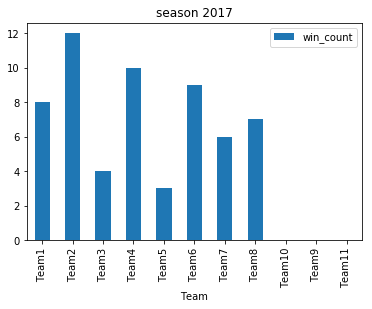

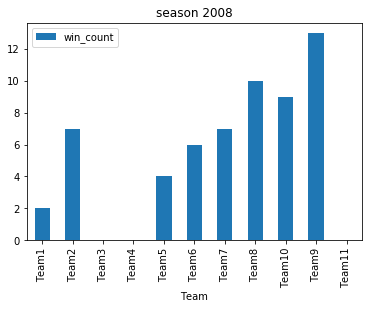

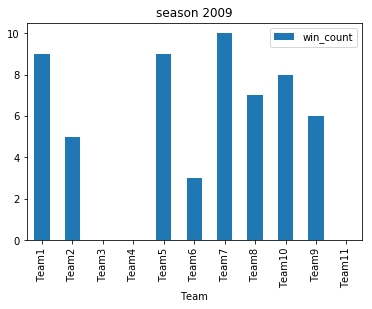

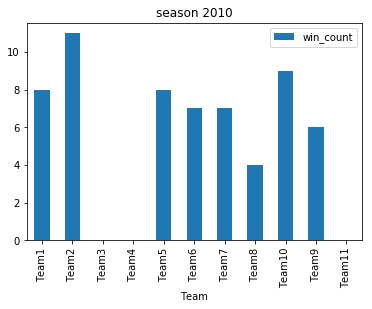

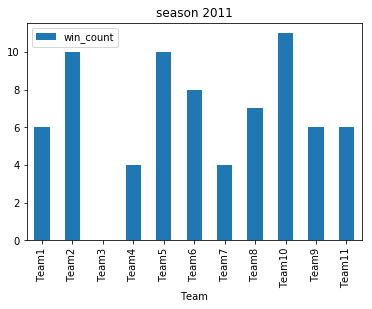

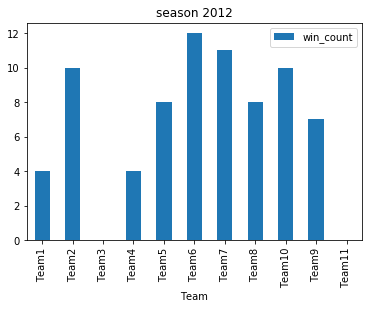

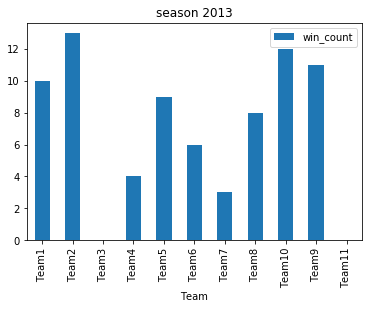

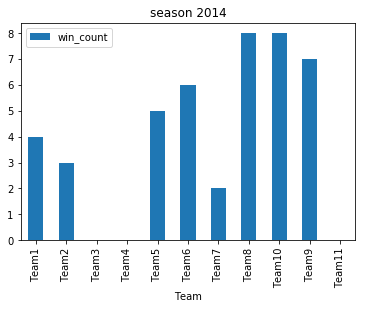

In [ ]:
# Adding season and winner to the feature table
FT["season"]=TRM["season"]
FT["winner"]=TRM["winner"]

#creating the season and team list
season_list=FT['season'].unique()
team_list=FT['Team A'].unique()

#Now check the frequency of each team won during every season

temp_data=pd.DataFrame() # Creating a temporary dataframe
temp_data["Team"]=team_list
temp_data.index=temp_data["Team"]

for s in season_list:
    winner_season=FT.loc[FT['season']== s,"winner"] # get the series of winners at the particular season
    t=winner_season.value_counts() # count the value of winning_count of each team
    t=t.to_frame() # Series is not efficient to work converting to a dataframe
    temp_data["win_count"]=t["winner"]
    temp_data['win_count']=temp_data['win_count'].fillna(0)
    temp_data['win_count']=temp_data['win_count'].astype(int)
    tit="season "+str(s)
    fig = plt.figure(figsize=(8,4))
    temp_data.plot(kind='bar',title=tit)

Hence from the above bar plots we can infer that the team_performance varies seasonally.So we concluded the seasonal values as an important feature to the feature table.

*** winner *** is our label we dont wanna add this feature by now we can add it later

In [ ]:
FT = FT.drop('winner', 1)

*** TOSS FEATURE ***

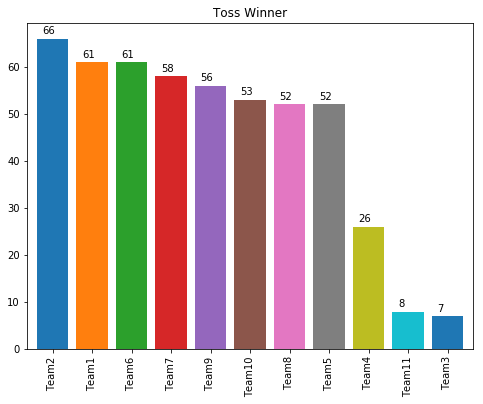

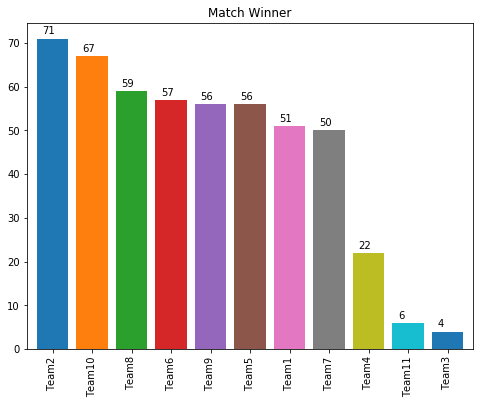

In [ ]:
teams=['Team1','Team2','Team3','Team4','Team5','Team6','Team7','Team8','Team9','Team10','Team11']
t=pd.Series(teams)
# finding the frequency of toss winners and the match winners to correlate
temp_toss_winner=pd.DataFrame()
temp_toss_winner['Team']=t.values
temp_match_winner=pd.DataFrame()
temp_match_winner['Team']=t.values

#Caluclating toss_winning and match winning frequency of each team
temp_toss_winner['Count'] = temp_toss_winner['Team'].map(TRM['toss_winner'].value_counts())
temp_match_winner['Count']=temp_match_winner['Team'].map(TRM['winner'].value_counts())

plt.subplots(figsize=(8,6))
ax=TRM['toss_winner'].value_counts().plot.bar(width=0.8)
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.title("Toss Winner")
plt.show()

plt.subplots(figsize=(8,6))
ax=TRM['winner'].value_counts().plot.bar(width=0.8)
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.title("Match Winner")
plt.show()

We have to know whether toss won act as a important role in winning decision.To check we have to visulaize a probablitic calculation.

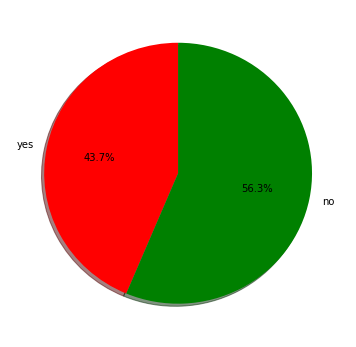

In [ ]:
df=TRM[TRM['toss_winner']==TRM['winner']]
slices=[len(df),(577-len(df))]
labels=['yes','no']
plt.pie(slices,labels=labels,startangle=90,shadow=True,explode=(0,0),autopct='%1.1f%%',colors=['r','g'])
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.show()

From this correaltion graph we can identify that toss winning also act as a major feature in predicting the result .From the graph we can infer that 43.7% toss winners are match winners.

In [ ]:
# Adding the toss_winner to the feature table
FT["toss_winner"]=TRM["toss_winner"]

** DUCKWORTH-LEWIS METHOD **

Duckworth-Lewis method(D/L method) is a mathematical function defined to set and calculate the target score for the team batting second in One day international cricket matches. It is the most complex and irritating function for the audience who are watching cricket. When duck-worth lewis method is appiled it may errupt the entire prediction system so we should as a feature table to avoid this type of scenarios.

In [ ]:

dl=TRM.loc[TRM['dl_applied'] == 1]
dl

,id,season,city,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue
id,,,,,,,,,,,,,,
57,57,2017,City5,Team1,Team6,Team6,field,normal,1,Team6,0,7,Player 286,Stadium5
100,100,2008,City9,Team7,Team8,Team7,bat,normal,1,Team8,6,0,Player 125,Stadium8
103,103,2008,City8,Team6,Team10,Team6,bat,normal,1,Team10,3,0,Player 236,Stadium7
120,120,2009,City14,Team8,Team7,Team7,field,normal,1,Team7,0,10,Player 120,Stadium14
123,123,2009,City16,Team8,Team6,Team6,field,normal,1,Team6,11,0,Player 87,Stadium16
149,149,2009,City17,Team10,Team8,Team10,bat,normal,1,Team10,12,0,Player 259,Stadium17
252,252,2011,City26,Team10,Team11,Team11,field,normal,1,Team11,0,7,Player 68,Stadium27
281,281,2011,City8,Team10,Team6,Team10,bat,normal,1,Team6,10,0,Player 161,Stadium7
291,291,2011,City5,Team6,Team5,Team5,field,normal,1,Team5,0,4,Player 87,Stadium5


Totally 10 matches is influenced by dl method the only go is to remove these 10 matches or add this as a feature to the feature table.But I select to add this as feature beacause our model will be trained to predict the *** dl applied mathches ***.

In [ ]:
FT["dl_applied"]=TRM["dl_applied"]
FT

,Team A,Team B,season,toss_winner,dl_applied
match_id,,,,,
1,Team1,Team5,2017,Team5,0
2,Team2,Team4,2017,Team4,0
3,Team3,Team6,2017,Team6,0
4,Team4,Team8,2017,Team8,0
5,Team5,Team7,2017,Team5,0
6,Team3,Team1,2017,Team1,0
7,Team6,Team2,2017,Team2,0
8,Team5,Team8,2017,Team5,0
9,Team7,Team4,2017,Team4,0


** VENUE FEATURE **

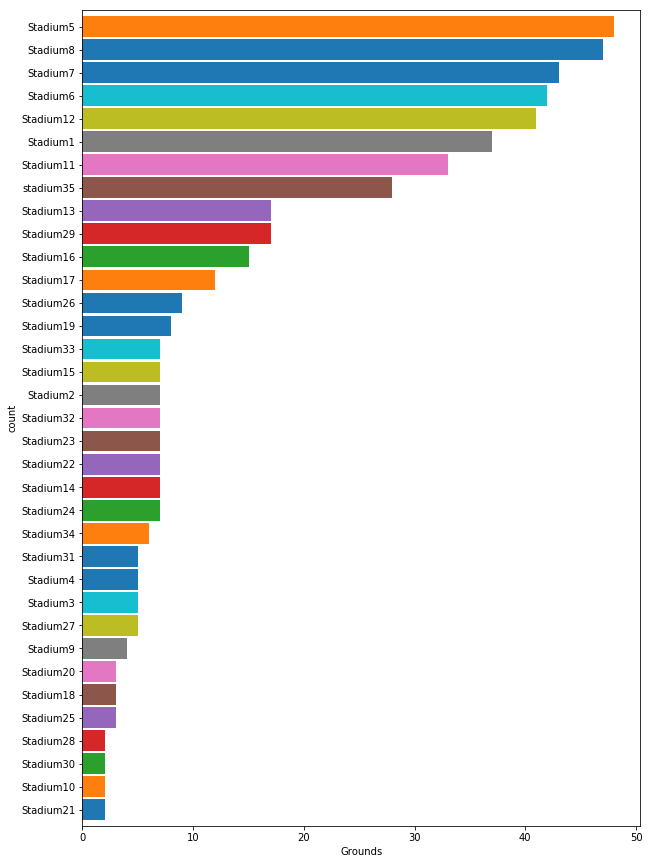

In [ ]:
plt.subplots(figsize=(10,15))
ax = TRM['venue'].value_counts().sort_values(ascending=True).plot.barh(width=.9)
ax.set_xlabel('Grounds')
ax.set_ylabel('count')
plt.show()

From this visualization we can infer that most matches are conducted only on major 7 statdiums .From this we can draw to a conclusion that stadium does not play a major role in deciding the victory compare to other features.

** TEAM DELIVERIES **

*** RUNS PER OVER ACROSS SEASON ***

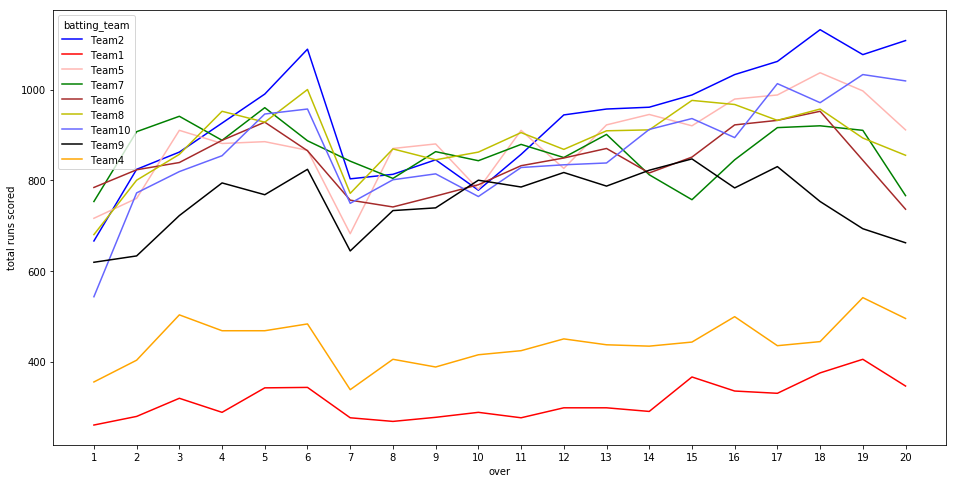

In [ ]:
runs_per_over = TRD.pivot_table(index=['over'],columns='batting_team',values='total_runs',aggfunc=sum)
runs_per_over[(matches_played_byteams[matches_played_byteams['Total Matches']>50].index)].plot(color=["b", "r", "#Ffb6b2", "g",'brown','y','#6666ff','black','#FFA500']) #plotting graphs for teams that have played more than 100 matches
x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.xticks(x)
plt.ylabel('total runs scored')
fig=plt.gcf()
fig.set_size_inches(16,8)
plt.show()

From this visualization we can say that we have to calculate the batting and bowling average of each team to calcuate the overall performance.

In [ ]:
def Batting_Averager(df):
    over_average=pd.DataFrame()
    overs=list(range(1, 21))
    o_a=[]
    o=pd.Series(overs)
    over_average['overs']=o.values
    for i in overs:
        over_temp_frame=df.loc[df['over']== i]
        total_bruns=over_temp_frame['bye_runs'].sum()
        total_lbruns=over_temp_frame['legbye_runs'].sum()
        b_non_zero=over_temp_frame.loc[over_temp_frame['batsman_runs'] != 0,"batsman_runs"].sum()
        b_dot=over_temp_frame.loc[over_temp_frame['batsman_runs']==0,"batsman_runs"].count()
        b_dis=over_temp_frame.loc[over_temp_frame['dismissal_kind'] != 'NaN',"dismissal_kind"].count()
        oa=(1*total_bruns+1*total_lbruns+2*b_non_zero-1*b_dot+-3*b_dis)/5
        o_a.append(oa)
    o_a=pd.Series(o_a)
    over_average['average']=o_a.values
    bat_av=over_average["average"].mean()
    return bat_av
#comment out no_of_50s/100s

def Bowling_Averager(df):
    over_average=pd.DataFrame()
    overs=list(range(1, 21))
    o_a=[]
    o=pd.Series(overs)
    over_average['overs']=o.values
    for i in overs:
        over_temp_frame=df.loc[df['over']== i]
        total_wr=over_temp_frame['wide_runs'].sum()
        total_nb=over_temp_frame['noball_runs'].sum()
        total_pr=over_temp_frame['penalty_runs'].sum()
        total_er=over_temp_frame['extra_runs'].sum()
        b_non_zero=over_temp_frame.loc[over_temp_frame['total_runs'] != 0,"total_runs"].sum()
        b_dot=over_temp_frame.loc[over_temp_frame['total_runs']==0,"total_runs"].count()
        b_dis=over_temp_frame.loc[over_temp_frame['dismissal_kind'] != 'NaN',"dismissal_kind"].count()
        oa=(-1*total_wr+-1*total_nb+-2*total_pr+-1*total_er+-2*b_non_zero+5*b_dot+10*b_dis)/7
        o_a.append(oa)
    o_a=pd.Series(o_a)
    over_average['average']=o_a.values
    bow_av=over_average["average"].mean()
    return(bow_av)
#runs per over conceded and wickets taken -> determinant in bowl_avg


#creating team_performance dataframe
team_performance=pd.DataFrame()
team_performance["match_id"]=TRM["id"]
team_performance.index=team_performance["match_id"]
team_performance["Team_A_Batting_Average"]=0.0
team_performance["Team_A_Bowling_Average"]=0.0
team_performance["Team_A_Total_Runs"]=0
team_performance["Team_B_Batting_Average"]=0.0
team_performance["Team_B_Bowling_Average"]=0.0
team_performance["Team_B_Total_Runs"]=0
team_performance["Team_A_overall"]=0.0
team_performance["Team_B_overall"]=0.0
team_performance["super_over"]='0'

# creating match_id list
match_id_list=TRM["id"].unique()
overs_list=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]


for m in match_id_list:
    match_frame=TRD.loc[TRD["match_id"]==m]
    temp=FT.loc[m,"Team A":"Team B"]
    team_dict=temp.to_dict()
    FLAG=False
    team_perform_dict={"match_id":m,"Team_A_Batting_Average":0.0,"Team_A_Bowling_Average":0.0,"Team_A_Total_Runs":0,"Team_B_Batting_Average":0.0,"Team_B_Bowling_Average":0.0,"Team_B_Total_Runs":0,"Team_A_overall":0.0,"Team_B_overall":0.0,"super_over":'0'}
    super_over=match_frame['is_super_over'].sum()

    if super_over==0:
        innings=match_frame["inning"].unique()
        super_over_innings=[]
    else :
        super_over_run={"Team_A_run":0,"Team_B_run":0}
        FLAG=True
        super_over_innings=[3,4]

    for i in innings:
        innings_frame=pd.DataFrame()
        innings_frame=match_frame.loc[match_frame['inning'] == i]
        batting_team=innings_frame.loc[innings_frame['inning']== i,"batting_team"].values[0]
        bowling_team=innings_frame.loc[innings_frame['inning']== i,"bowling_team"].values[0]

        if(team_dict['Team A']==batting_team):
            batting_team_frame=innings_frame[['over','ball','bye_runs','legbye_runs','batsman_runs','dismissal_kind']]
            bowling_team_frame=innings_frame[['over','ball','wide_runs','noball_runs','penalty_runs','extra_runs','total_runs','dismissal_kind']]
            team_perform_dict["Team_A_Batting_Average"]=Batting_Averager(batting_team_frame)
            team_perform_dict["Team_B_Bowling_Average"]=Bowling_Averager(bowling_team_frame)
            team_perform_dict["Team_A_Total_Runs"] =innings_frame['total_runs'].sum()

        elif(team_dict['Team B']==batting_team):
            batting_team_frame=innings_frame[['over','ball','bye_runs','legbye_runs','batsman_runs','dismissal_kind']]
            bowling_team_frame=innings_frame[['over','ball','wide_runs','noball_runs','penalty_runs','extra_runs','total_runs','dismissal_kind']]
            team_perform_dict["Team_B_Batting_Average"]=Batting_Averager(batting_team_frame)
            team_perform_dict["Team_A_Bowling_Average"]=Bowling_Averager(bowling_team_frame)
            team_perform_dict["Team_B_Total_Runs"]=innings_frame['total_runs'].sum()

    for i in super_over_innings:
        innings_frame=pd.DataFrame()
        innings_frame=match_frame.loc[match_frame['inning']==i]
        batting_team=innings_frame.loc[innings_frame['inning']== i,"batting_team"].values[0]
        if(team_dict['Team A']==batting_team):
            super_over_run["Team_A_run"]=innings_frame['total_runs'].sum()
        elif(team_dict['Team B']==batting_team):
            super_over_run["Team_B_run"]=innings_frame['total_runs'].sum()

    if FLAG:
        if super_over_run["Team_A_run"]>super_over_run["Team_B_run"]:
            team_perform_dict['super_over']='A'
        elif super_over_run["Team_B_run"]>super_over_run["Team_A_run"]:
            team_perform_dict['super_over']='B'

    team_perform_dict["Team_A_overall"]=(team_perform_dict["Team_A_Batting_Average"]+team_perform_dict["Team_A_Bowling_Average"])/2
    team_perform_dict["Team_B_overall"]=(team_perform_dict["Team_B_Batting_Average"]+team_perform_dict["Team_B_Bowling_Average"])/2


    df=pd.DataFrame([team_perform_dict],columns=team_perform_dict.keys())
    df.index=df["match_id"]
    match=df["match_id"].unique()
    team_performance.loc[match,:]= df.loc[df["match_id"],:]


team_performance

,match_id,Team_A_Batting_Average,Team_A_Bowling_Average,Team_A_Total_Runs,Team_B_Batting_Average,Team_B_Bowling_Average,Team_B_Total_Runs,Team_A_overall,Team_B_overall,super_over
match_id,,,,,,,,,,
1,1,3.57,-0.250000,207,2.54,-1.835714,172,1.660000,0.352143,0
2,2,2.82,-1.471429,184,3.25,-0.692857,187,0.674286,1.278571,0
3,3,3.09,-2.064286,183,3.13,-1.121429,184,0.512857,1.004286,0
4,4,2.59,-0.764286,163,2.48,-0.835714,164,0.912857,0.822143,0
5,5,2.24,0.228571,157,1.96,0.042857,142,1.234286,1.001429,0
6,6,2.07,-1.007143,135,2.41,-0.164286,140,0.531429,1.122857,0
7,7,2.77,-0.564286,178,2.65,-0.914286,180,1.102857,0.867857,0
8,8,2.20,-1.307143,148,2.59,0.014286,150,0.446429,1.302143,0
9,9,3.45,0.571429,205,1.31,-1.592857,108,2.010714,-0.141429,0


**  PLAYER OF EACH MATCH **

Player of the match will be the one who denots the extraordinary work and most probably they belong to the winning team .So we may consider this feature also a bonus one to enhance our model.
    

In [ ]:

player_match_frame=pd.DataFrame()
player_match_frame["match_id"]=TRM["id"]
player_match_frame.index=player_match_frame["match_id"]
player_match_frame["man_of_match"]='NOT_IN_TEAM'
match_id_list=TRM["id"].unique()

for m in match_id_list:
    player=TRM.loc[TRM['id']== m,"player_of_match"].values[0]
    match_frame=TRD.loc[TRD["match_id"]==m]
    temp=FT.loc[m,"Team A":"Team B"]
    team_dict=temp.to_dict()
    TEAM_A_BATSMAN=match_frame.loc[match_frame['batting_team']==team_dict["Team A"],["batsman","non_striker"]]
    TEAM_A_BOWLERS=match_frame.loc[match_frame['bowling_team']==team_dict["Team A"],["bowler"]]
    TEAM_A_MEMBERS=set(list(TEAM_A_BATSMAN["batsman"].unique())+list(TEAM_A_BATSMAN["non_striker"].unique())+list(TEAM_A_BOWLERS["bowler"].unique()))
    TEAM_B_BATSMAN=match_frame.loc[match_frame['batting_team']==team_dict["Team B"],["batsman","non_striker"]]
    TEAM_B_BOWLERS=match_frame.loc[match_frame['bowling_team']==team_dict["Team B"],["bowler"]]
    TEAM_B_MEMBERS=set(list(TEAM_B_BATSMAN["batsman"].unique())+list(TEAM_B_BATSMAN["non_striker"].unique())+list(TEAM_B_BOWLERS["bowler"].unique()))
    if player in TEAM_A_MEMBERS:
        player_match_frame.at[m, 'man_of_match'] = 'A'
    elif player in TEAM_B_MEMBERS:
        player_match_frame.at[m,"man_of_match"]='B'
player_match_frame


,match_id,man_of_match
match_id,,
1,1,A
2,2,B
3,3,B
4,4,NOT_IN_TEAM
5,5,NOT_IN_TEAM
6,6,NOT_IN_TEAM
7,7,NOT_IN_TEAM
8,8,NOT_IN_TEAM
9,9,NOT_IN_TEAM


In [ ]:
winner_frame=pd.DataFrame()
winner_frame["match_id"]=TRM["id"]
winner_frame.index=winner_frame["match_id"]
winner_frame["winner"]=0
match_id_list=TRM["id"].unique()

for m in match_id_list:
    winner=TRM.loc[TRM['id']== m,"winner"].values[0]
    temp=FT.loc[m,"Team A":"Team B"]
    team_dict=temp.to_dict()
    if(winner==team_dict["Team A"]):
        winner_frame.at[m, 'winner'] = 0
    elif(winner==team_dict["Team B"]):
        winner_frame.at[m,'winner']=1

winner_frame


,match_id,winner
match_id,,
1,1,0
2,2,1
3,3,1
4,4,1
5,5,0
6,6,1
7,7,1
8,8,1
9,9,0


From this analytics we can infer that player_of_match given in TrainMatchesdataset is collapsed and they are giving the mismatched result.So We can neglect this feature.

** PREPARATION OF FEATURE TABLE **

In [ ]:
def Batting_Averager(df):
    over_average=pd.DataFrame()
    overs=list(range(1, 21))
    o_a=[]
    o=pd.Series(overs)
    over_average['overs']=o.values
    for i in overs:
        over_temp_frame=df.loc[df['over']== i]
        total_bruns=over_temp_frame['bye_runs'].sum()
        total_lbruns=over_temp_frame['legbye_runs'].sum()
        b_non_zero=over_temp_frame.loc[over_temp_frame['batsman_runs'] != 0,"batsman_runs"].sum()
        b_dot=over_temp_frame.loc[over_temp_frame['batsman_runs']==0,"batsman_runs"].count()
        b_dis=over_temp_frame.loc[over_temp_frame['dismissal_kind'] != 'NaN',"dismissal_kind"].count()
        oa=(1*total_bruns+1*total_lbruns+2*b_non_zero+-1*b_dot+-3*b_dis)/5
        o_a.append(oa)
    o_a=pd.Series(o_a)
    over_average['average']=o_a.values
    bat_av=over_average["average"].mean()
    return bat_av


def Bowling_Averager(df):
    over_average=pd.DataFrame()
    overs=list(range(1, 21))
    o_a=[]
    o=pd.Series(overs)
    over_average['overs']=o.values
    for i in overs:
        over_temp_frame=df.loc[df['over']== i]
        total_wr=over_temp_frame['wide_runs'].sum()
        total_nb=over_temp_frame['noball_runs'].sum()
        total_pr=over_temp_frame['penalty_runs'].sum()
        total_er=over_temp_frame['extra_runs'].sum()
        b_non_zero=over_temp_frame.loc[over_temp_frame['total_runs'] != 0,"total_runs"].sum()
        b_dot=over_temp_frame.loc[over_temp_frame['total_runs']==0,"total_runs"].count()
        b_dis=over_temp_frame.loc[over_temp_frame['dismissal_kind'] != 'NaN',"dismissal_kind"].count()
        oa=(-1*total_wr+-1*total_nb+-2*total_pr+-1*total_er+-2*b_non_zero+5*b_dot+10*b_dis)/7
        o_a.append(oa)
    o_a=pd.Series(o_a)
    over_average['average']=o_a.values
    bow_av=over_average["average"].mean()
    return(bow_av)



def df_feature(TRM,TRD,T):
    # Creating Feature Table
    F_T=pd.DataFrame()

    # Making match_id as the index
    F_T["match_id"]=TRM["id"]
    F_T.index=F_T["match_id"]

    # Adding Team Deatils
    F_T["Team A"]=TRM["team1"]
    F_T["Team B"]=TRM["team2"]

    # Adding Season Feature
    F_T["season"]=TRM["season"]

    # Adding Toss Winner Feature
    F_T["toss_winner"]=TRM["toss_winner"]

    # Adding dl feature
    F_T["dl_applied"]=TRM["dl_applied"]

    #Adding cross validation features
    #creating team_performance dataframe
    team_performance=pd.DataFrame()
    team_performance["match_id"]=TRM["id"]
    team_performance.index=team_performance["match_id"]
    team_performance["Team_A_Batting_Average"]=0.0
    team_performance["Team_A_Bowling_Average"]=0.0
    team_performance["Team_A_Total_Runs"]=0.0
    team_performance["Team_B_Batting_Average"]=0.0
    team_performance["Team_B_Bowling_Average"]=0.0
    team_performance["Team_B_Total_Runs"]=0.0
    team_performance["Team_A_overall"]=0.0
    team_performance["Team_B_overall"]=0.0
    team_performance["super_over"]='0'

    # creating match_id list
    match_id_list=TRM["id"].unique()
    overs_list=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]


    for m in match_id_list:
        match_frame=TRD.loc[TRD["match_id"]==m]
        temp=F_T.loc[m,"Team A":"Team B"]
        team_dict=temp.to_dict()
        FLAG=False
        team_perform_dict={"match_id":m,"Team_A_Batting_Average":0.0,"Team_A_Bowling_Average":0.0,"Team_A_Total_Runs":0,"Team_B_Batting_Average":0.0,"Team_B_Bowling_Average":0.0,"Team_B_Total_Runs":0,"Team_A_overall":0.0,"Team_B_overall":0.0,"super_over":0}
        super_over=match_frame['is_super_over'].sum()

        if super_over==0:
            innings=match_frame["inning"].unique()
            super_over_innings=[]
        else :
            super_over_run={"Team_A_run":0,"Team_B_run":0}
            FLAG=True
            super_over_innings=[3,4]

        for i in innings:
            innings_frame=pd.DataFrame()
            innings_frame=match_frame.loc[match_frame['inning'] == i]
            batting_team=innings_frame.loc[innings_frame['inning']== i,"batting_team"].values[0]
            bowling_team=innings_frame.loc[innings_frame['inning']== i,"bowling_team"].values[0]

            if(team_dict['Team A']==batting_team):
                batting_team_frame=innings_frame[['over','ball','bye_runs','legbye_runs','batsman_runs','dismissal_kind']]
                bowling_team_frame=innings_frame[['over','ball','wide_runs','noball_runs','penalty_runs','extra_runs','total_runs','dismissal_kind']]
                team_perform_dict["Team_A_Batting_Average"]=Batting_Averager(batting_team_frame)
                team_perform_dict["Team_B_Bowling_Average"]=Bowling_Averager(bowling_team_frame)
                team_perform_dict["Team_A_Total_Runs"] =innings_frame['total_runs'].sum()

            elif(team_dict['Team B']==batting_team):
                batting_team_frame=innings_frame[['over','ball','bye_runs','legbye_runs','batsman_runs','dismissal_kind']]
                bowling_team_frame=innings_frame[['over','ball','wide_runs','noball_runs','penalty_runs','extra_runs','total_runs','dismissal_kind']]
                team_perform_dict["Team_B_Batting_Average"]=Batting_Averager(batting_team_frame)
                team_perform_dict["Team_A_Bowling_Average"]=Bowling_Averager(bowling_team_frame)
                team_perform_dict["Team_B_Total_Runs"] =innings_frame['total_runs'].sum()

        for i in super_over_innings:
            innings_frame=pd.DataFrame()
            innings_frame=match_frame.loc[match_frame['inning']==i]
            batting_team=innings_frame.loc[innings_frame['inning']== i,"batting_team"].values[0]
            if(team_dict['Team A']==batting_team):
                super_over_run["Team_A_run"]=innings_frame['total_runs'].sum()
            elif(team_dict['Team B']==batting_team):
                super_over_run["Team_B_run"]=innings_frame['total_runs'].sum()

        if FLAG:
            if super_over_run["Team_A_run"]>super_over_run["Team_B_run"]:
                team_perform_dict['super_over']=1
            elif super_over_run["Team_B_run"]>super_over_run["Team_A_run"]:
                team_perform_dict['super_over']=2

        team_perform_dict["Team_A_overall"]=(team_perform_dict["Team_A_Batting_Average"]+team_perform_dict["Team_A_Bowling_Average"])/2
        team_perform_dict["Team_B_overall"]=(team_perform_dict["Team_B_Batting_Average"]+team_perform_dict["Team_B_Bowling_Average"])/2


        df=pd.DataFrame([team_perform_dict],columns=team_perform_dict.keys())
        df.index=df["match_id"]
        match=df["match_id"].unique()
        team_performance.loc[match,:]= df.loc[df["match_id"],:]

    F_T["Team_A_Batting_Average"]=team_performance["Team_A_Batting_Average"]
    F_T["Team_A_Bowling_Average"]=team_performance["Team_A_Bowling_Average"]
    F_T["Team_A_Total_Runs"]=team_performance["Team_A_Total_Runs"]
    F_T["Team_B_Batting_Average"]=team_performance["Team_B_Batting_Average"]
    F_T["Team_B_Bowling_Average"]=team_performance["Team_B_Bowling_Average"]
    F_T["Team_B_Total_Runs"]=team_performance["Team_B_Total_Runs"]
    F_T["Team_A_overall"]=team_performance["Team_A_overall"]
    F_T["Team_B_overall"]=team_performance["Team_B_overall"]
    F_T["super_over"]=team_performance["super_over"]

    if(T):
        #Winner Field
        winner_frame=pd.DataFrame()
        winner_frame["match_id"]=TRM["id"]
        winner_frame.index=winner_frame["match_id"]
        winner_frame["winner"]=0
        match_id_list=TRM["id"].unique()

        for m in match_id_list:
            winner=TRM.loc[TRM['id']== m,"winner"].values[0]
            temp=F_T.loc[m,"Team A":"Team B"]
            team_dict=temp.to_dict()
            if(winner==team_dict["Team A"]):
                winner_frame.at[m, 'winner'] = 0
            elif(winner==team_dict["Team B"]):
                winner_frame.at[m,'winner']=1

        #Adding Winner Field to F_T
        F_T["winner"]=winner_frame["winner"]

    return F_T



In [ ]:
T=True
train=df_feature(TRM,TRD,T)

In [ ]:
train

,match_id,Team A,Team B,season,toss_winner,dl_applied,Team_A_Batting_Average,Team_A_Bowling_Average,Team_A_Total_Runs,Team_B_Batting_Average,Team_B_Bowling_Average,Team_B_Total_Runs,Team_A_overall,Team_B_overall,super_over,winner
match_id,,,,,,,,,,,,,,,,
1,1,Team1,Team5,2017,Team5,0,3.57,-0.250000,207.0,2.54,-1.835714,172.0,1.660000,0.352143,0,0
2,2,Team2,Team4,2017,Team4,0,2.82,-1.471429,184.0,3.25,-0.692857,187.0,0.674286,1.278571,0,1
3,3,Team3,Team6,2017,Team6,0,3.09,-2.064286,183.0,3.13,-1.121429,184.0,0.512857,1.004286,0,1
4,4,Team4,Team8,2017,Team8,0,2.59,-0.764286,163.0,2.48,-0.835714,164.0,0.912857,0.822143,0,1
5,5,Team5,Team7,2017,Team5,0,2.24,0.228571,157.0,1.96,0.042857,142.0,1.234286,1.001429,0,0
6,6,Team3,Team1,2017,Team1,0,2.07,-1.007143,135.0,2.41,-0.164286,140.0,0.531429,1.122857,0,1
7,7,Team6,Team2,2017,Team2,0,2.77,-0.564286,178.0,2.65,-0.914286,180.0,1.102857,0.867857,0,1
8,8,Team5,Team8,2017,Team5,0,2.20,-1.307143,148.0,2.59,0.014286,150.0,0.446429,1.302143,0,1
9,9,Team7,Team4,2017,Team4,0,3.45,0.571429,205.0,1.31,-1.592857,108.0,2.010714,-0.141429,0,0


In [ ]:
train_feature=["season", "dl_applied",
               "Team_A_Batting_Average", "Team_A_Bowling_Average",
               "Team_A_Total_Runs",
                "Team_B_Batting_Average", "Team_B_Bowling_Average",
               "Team_B_Total_Runs",
                "Team_A_overall","Team_B_overall","super_over"]





X_train, X_test, y_train, y_test = train_test_split(train[train_feature],train["winner"], test_size = 0.2, random_state = 10)
#one_hot_encoded_training_predictors=one_hot_encoded_training_predictors.drop('toss_winner_Team11',1)


** USING NAVIE_BAYES ALGORITHM **

The accuracy using NB is: 91.0


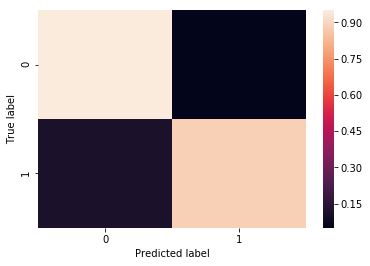

In [ ]:
#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets
model.fit(X_train,y_train)

#Predict Output
predicted= model.predict(X_test)
a = accuracy_score(y_test,predicted)
print('The accuracy using NB is:',format(a*100))

conf_mat = confusion_matrix(y_test, predicted)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

** DECISION TREE REGRESSOR **

The accuracy using DecisionTreeRegressor is: 89.0


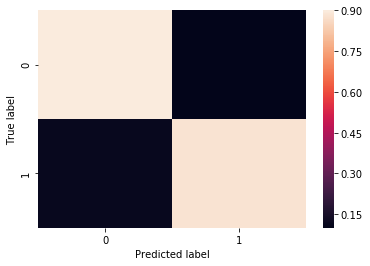

In [ ]:
# Define model
DT_model = DecisionTreeRegressor()

# Fit model
DT_model.fit(X_train, y_train)

#Predict Output
predicted= DT_model.predict(X_test)
a = accuracy_score(y_test,predicted)
print('The accuracy using DecisionTreeRegressor is:',format(a*100))

conf_mat = confusion_matrix(y_test, predicted)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

** SUPPORT VECTOR MACHINE **

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



The accuracy using SVC Classifier is: 85.0


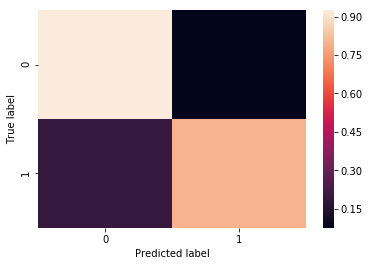

In [ ]:
# Define model
SVC_model = svm.SVC()

# Fit model
SVC_model.fit(X_train, y_train)

#Predict Output
predicted= SVC_model.predict(X_test)
a = accuracy_score(y_test,predicted)
print('The accuracy using SVC Classifier is:',format(a*100))

conf_mat = confusion_matrix(y_test, predicted)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

** RANDOM FOREST ALGORITHM **

The accuracy using RandomForest Classifier is: 89.0


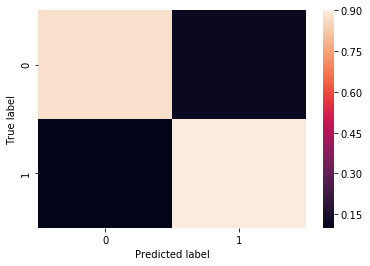

In [ ]:
# Define model
RF_model = RandomForestClassifier(max_depth=2, random_state=0)

# Fit model
RF_model.fit(X_train, y_train)

#Predict Output
predicted= RF_model.predict(X_test)
a = accuracy_score(y_test,predicted)
print('The accuracy using RandomForest Classifier is:',format(a*100))

conf_mat = confusion_matrix(y_test, predicted)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
TTM=pd.read_csv("../input/Testmatches.csv")
TTM["id"]=TTM["match_id"]
TTM = TTM.drop('match_id', 1)
TTM.index=TTM["id"]
TTD=pd.read_csv("../input/TestDeliveries.csv")
T=False
test_df = df_feature(TTM,TTD,T)

test_df

,match_id,Team A,Team B,season,toss_winner,dl_applied,Team_A_Batting_Average,Team_A_Bowling_Average,Team_A_Total_Runs,Team_B_Batting_Average,Team_B_Bowling_Average,Team_B_Total_Runs,Team_A_overall,Team_B_overall,super_over
match_id,,,,,,,,,,,,,,,
501,501,Team2,Team9,2014,Team2,0,2.94,0.064286,178.0,2.09,-1.035714,153.0,1.502143,0.527143,0
502,502,Team7,Team8,2014,Team8,0,2.50,-0.435714,164.0,2.24,-0.371429,165.0,1.032143,0.934286,0
503,503,Team5,Team1,2014,Team5,0,2.42,-0.621429,160.0,2.53,-0.400000,161.0,0.899286,1.065000,0
504,504,Team10,Team6,2014,Team6,0,2.43,-0.978571,154.0,2.65,-0.385714,156.0,0.725714,1.132143,0
505,505,Team8,Team2,2014,Team2,0,2.18,-0.842857,156.0,2.45,0.192857,159.0,0.668571,1.321429,0
506,506,Team6,Team5,2014,Team5,0,3.21,-0.764286,195.0,2.60,-1.192857,165.0,1.222857,0.703571,0
507,507,Team10,Team1,2014,Team1,0,3.07,-1.300000,185.0,3.20,-1.028571,189.0,0.885000,1.085714,0
508,508,Team2,Team7,2014,Team7,0,2.67,-0.571429,173.0,2.49,-0.735714,158.0,1.049286,0.877143,0
509,509,Team8,Team9,2014,Team9,0,2.81,-0.292857,179.0,2.42,-1.042857,163.0,1.258571,0.688571,0


In [ ]:
sub=pd.read_csv("../input/submission.csv")
sub.index=sub["match_id"]

In [ ]:
print("Predicting...")
sub['team_1_win_flag'] =model.predict(test_df[train_feature])
sub.team_1_win_flag.replace([0,1], [1, 0], inplace=True)
print("writing...")
sub.to_csv('sub1.csv', index = False)
test_df.to_csv('test.csv',index=False)
print("done...")
print(sub.info())

Predicting...
writing...
done...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 501 to 636
Data columns (total 2 columns):
match_id           136 non-null int64
team_1_win_flag    136 non-null int64
dtypes: int64(2)
memory usage: 3.2 KB
None
